In [21]:
import pandas as pd
import numpy as np
import spacy
import json
import re

import seaborn as sns
import matplotlib.pyplot as plt

from guess_language import guess_language
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [22]:
DATA_PATH = 'D:/Data_Science/mentoring/src/preprocessed-data/'

In [23]:
posts = pd.read_csv(f'{DATA_PATH}teams_2_3_8_10_posts.csv', sep=';', index_col=0)
print(posts.info())
posts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9802 entries, 0 to 9801
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    9802 non-null   object 
 1   post_url       117 non-null    object 
 2   post           9802 non-null   object 
 3   reactions_cnt  9653 non-null   object 
 4   comments_cnt   9467 non-null   float64
 5   reposts_cnt    9356 non-null   float64
dtypes: float64(2), object(4)
memory usage: 536.0+ KB
None


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Кстати говоря. Теперь подкаст Миражи доступен ...,1,0.0,0.0
1,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,I’m #hiring. Know anyone who might be interested?,1,0.0,0.0
2,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Хэй честной народ! Ищу векторного иллюстратора...,6,0.0,0.0
3,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Новый пост подкаста ""Миражи"" на всех платформа...",1,0.0,0.0
4,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Подкаст Миражи, Эпизод 13Ошибка невозвратных з...",2,0.0,0.0


# Категоризация текстов по языку

Так как при парсинге в выборку попадали тексты на разных языках, произведем категоризацию по ним, используя библиотеку `guess_language`

In [24]:
posts['language'] = posts['post'].apply(guess_language)
posts.sample(10)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language
6470,https://www.linkedin.com/in/yuliya-l-b60416223...,NaN,Какой UI вам больше всего понравился?,3,0.0,0.0,ru
6060,https://www.linkedin.com/in/gorpoghosyan/recen...,NaN,𝐇𝐨𝐰 𝐓𝐨 𝐋𝐞𝐯𝐞𝐫𝐚𝐠𝐞 𝐄𝐦𝐨𝐭𝐢𝐨𝐧𝐚𝐥 𝐈𝐧𝐭𝐞𝐥𝐥𝐢𝐠𝐞𝐧𝐜𝐞 𝐈𝐧 𝐓𝐡𝐞 ...,4,0.0,0.0,en
9319,https://www.linkedin.com/in/averkieff,NaN,"Transatlantic Cable podcast, episode 96",NaN,NaN,NaN,ca
7729,https://www.linkedin.com/in/arybalko/recent-ac...,NaN,JUST IN: OpenAI is adding support for plugins ...,461,19.0,48.0,en
8633,https://www.linkedin.com/in/selesnow/recent-ac...,NaN,Добавляем подграфики распределения данных по о...,17,0.0,0.0,ru
6846,https://www.linkedin.com/in/pikman/recent-acti...,NaN,I used #ChatGPT and #DallE2 to create children...,9,2.0,1.0,en
1761,https://www.linkedin.com/in/tudor-c-449a9522b/...,NaN,We called it 'Purple Mood'Our inst : @spaceaim...,0,0.0,0.0,en
6781,https://www.linkedin.com/in/vladislav-popov-20...,NaN,"Здравствуйте, я в поиске новой карьерной возмо...",52,0.0,9.0,ru
8331,https://www.linkedin.com/in/alexander-berezovs...,NaN,"Uman, Ukraine, 8.06.2023#russiaisaterrorisstat...",252,8.0,33.0,fr
8619,https://www.linkedin.com/in/selesnow/recent-ac...,NaN,Язык R: Пакет для поиска пакетов на CRANПакет ...,4,1.0,0.0,bg


По десяти случайным строкам видно, что есть категория UNKNOWN и какие-то языки кроме английского и русского. Посмотрим внимательнее

In [25]:
posts['language'].value_counts()

en         6056
ru         2287
UNKNOWN     386
uk          226
bg          181
fr           77
de           47
ca           42
af           38
az           36
mk           35
it           35
nl           33
da           32
ro           30
hy           29
la           29
es           21
tl           17
nb           17
eo           15
sr           13
sv           13
ar           11
pt           11
id           10
fi            7
ha            7
nso           6
haw           4
he            4
sl            4
kk            4
sq            3
tr            3
ss            3
cy            3
uz            3
is            3
hr            3
et            2
ceb           2
hu            2
tn            2
sk            2
vi            1
so            1
ka            1
ve            1
tlh           1
st            1
ky            1
lt            1
Name: language, dtype: int64

Большинство текстов написаны на  русском и английском языках. Визуально посмотрим, на тексты иных языков 'uk', 'bg', 'fr' и категорию `unknown`. Эти категории мамые популярные:

In [26]:
posts.query('language == "UNKNOWN"')[['post', 'language']].sample(10)

,post,language
5546,I’m #hiring #backend,UNKNOWN
6465,I love abstract art,UNKNOWN
6046,my dream team,UNKNOWN
5833,I'll be there!,UNKNOWN
4119,Easy algorithm:),UNKNOWN
391,#lean #leanglossary,UNKNOWN
705,October Tech Picks,UNKNOWN
5093,Have a great week 🍀,UNKNOWN
2965,Biden the Grey…..,UNKNOWN
8988,Пахаххахаха,UNKNOWN


Похоже, это очень короткие тексты, которые нам особо не пригодятся. Исключим из выборки

In [27]:
posts.query('language == "uk"')[['post', 'language']].sample(10)

,post,language
8215,Добрий день! Моя основна праця з 2011 р. фотор...,uk
5048,Favbet та Міністерство молоді та спорту Україн...,uk
4566,На наступному тижні відриваємо додаткові вакан...,uk
9526,нужен кому автоматизатор с опытом? беру дорого.,uk
4653,"Part 1/3(English below) Воу, вже 31 грудня. То...",uk
4578,#NeutralWhiteSPORTНейтрально-білий спорт,uk
4569,Ми робимо не тількі сайти. В нас також є дуже ...,uk
3291,Одна гарна людина запропонувала мені завести а...,uk
9306,Vitali Kashko #Отзывы с благодарностью Вы вдох...,uk
5056,Катрін Денев прочитала вірш Лесі Українки на в...,uk


Украинский язык (логично :-)). Для того, чтобы не подгружать множество языковых моделей, думаю, что целесообразно исключить его из общей выборки. Сосредоточимся на наиболее популярных языках 'ru' и 'en'. Посмотрим 'bg':

In [28]:
posts.query('language == "bg"')[['post', 'language']].sample(10)

,post,language
7242,Logo исследованиеКакой лучше?Обратная связь це...,bg
335,Классные кейсы! Особенно в первом кейсе впечат...,bg
3651,И два контейнера с постгрей и дженкинсом 😱#IT ...,bg
8313,⚡️Полк Каліноўскага рыхтуе зварот да беларуска...,bg
9092,В Big Data Мегафон ищем Team Lead Data Analyti...,bg
260,«Погнали в IT»Новое направление!Разработка пол...,bg
3949,Внимание! Большой IT и бизнес ивент в Бишкеке!...,bg
2752,"Привет, мир!Наконец-то холодное время позади и...",bg
1356,"26 июля, еще один день когда я ищу работу выпо...",bg
830,Когда устал от отказов 😒,bg


Большинство текстов с такой меткой написаны на русском. Думаю, что стоит поменять метку языка 'bg' на 'ru'

In [29]:
posts.query('language == "fr"')[['post', 'language']].sample(10)

,post,language
791,#taskmanagement #productivity,fr
7178,It’s not Mars. Russians hit Zaporizhzhia with ...,fr
358,Bubblemorph mobile appFashion design trendsett...,fr
6232,Интересная рассылка от mvideo@sender.mvideo.ru...,fr
3941,Animation Process #motiondesign #aftereffects,fr
6120,PlayStation - UX/UI ConceptDribble: https://ln...,fr
7033,Corporate Results Roundup Q1 2023 https://lnkd...,fr
8124,Check out our latest Newsletter post ⤵,fr
8179,Risk Assessment by Tom 😂😂#riskassessment #risk...,fr
8020,Wrote a post on how to check your DV-LOTTERY 2...,fr


Большой разброс по фактическим языкам. Думаю, что эту категорию не стоит включать в выборку. Подкорректируем метки функцией и посмотрим, что получилось:

In [30]:
def lang_correction(text):
    if text == 'bg':
        return 'ru'
    elif text == 'UNKNOWN' or text == 'ru' or text == 'en':
        return text
    else:
        return 'UNKNOWN'

In [31]:
posts['language'] = posts['language'].apply(lang_correction)
posts['language'].value_counts()

en         6056
ru         2468
UNKNOWN    1278
Name: language, dtype: int64

Метка UNKNOWN позволит нам легко исключить ненужные нам для анализа тексты. А что с длиной текстов. Построим распределение:

In [32]:
def post_len(text):
    return len(text)

posts['post_len'] = posts['post'].apply(post_len)

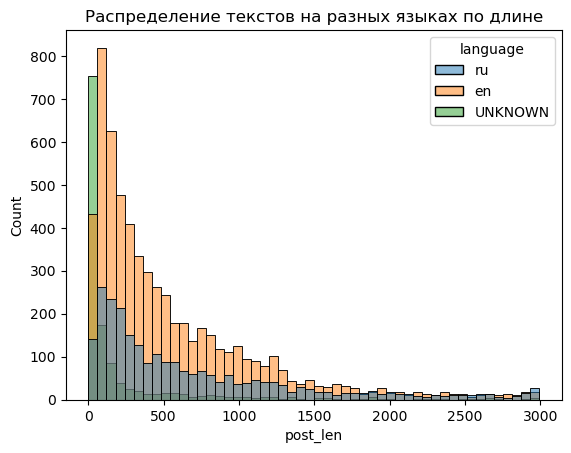

In [33]:
sns.histplot(posts, x='post_len',
                    hue="language").set_title('Распределение текстов на разных языках по длине')
plt.show()

Большинство текстов на русском и английском языках длиной меньше 500 символов. Также подтверждается гипотеза, что метка UNKNOWN в значимой степени связана с длиной текста (гистограмма резче остальных показывает спад количества с увеличением длины).

In [34]:
posts_en = posts.query('language == "en"')
posts_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len
1298,https://www.linkedin.com/in/andrey-mashukov/re...,NaN,"Hello everyone, we are #open for new #opportun...",3,1.0,0.0,en,467
9422,https://www.linkedin.com/in/alexsvetlakov,NaN,"Remember, you're choosing specific frameworks ...",NaN,NaN,NaN,en,142
8310,https://www.linkedin.com/in/andrrey/recent-act...,NaN,DXC Technology today announced an agreement to...,2,0.0,0.0,en,260
7269,https://www.linkedin.com/in/anna-pronina/recen...,NaN,"As you can see, our team is visiting a lot of ...",17,0.0,0.0,en,1141
7412,https://www.linkedin.com/in/cyrilbialo/recent-...,NaN,Russian representative on miss universe contes...,"2,019",97.0,221.0,en,359


In [35]:
posts_ru = posts.query('language == "ru"')
posts_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len
838,https://www.linkedin.com/in/ordalion/recent-ac...,NaN,Делал тестовое для Тинькофф. В кейсе расписал ...,30,0.0,0.0,ru,181
2058,https://www.linkedin.com/in/ferrethikky/recent...,NaN,Ветряные мельницы или как работа прóдуктов в «...,11,0.0,0.0,ru,2633
9027,https://www.linkedin.com/in/misikhin,NaN,Не пропустите вебинар с автором интересной кни...,2,0.0,0.0,ru,72
2608,https://www.linkedin.com/in/linkwolf/recent-ac...,NaN,Я вот написал новую статью! Получалась очень и...,1,0.0,0.0,ru,270
3940,https://www.linkedin.com/in/bekuzba/recent-act...,NaN,Бекназар покорил 3 IT-гиганта! Вот это результ...,29,0.0,1.0,ru,975


# Подготовка текстов

Скачаем и загрузим модели (библиотеку spacy предварительно установили)

In [36]:
! python -m spacy download ru_core_news_sm >> None
! python -m spacy download en_core_web_sm >> None

In [37]:
model_en = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
model_ru = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Сохраним посты на английском и русском языках, как списки

In [38]:
posts_ru_list = list(posts_ru['post'])
posts_en_list = list(posts_en['post'])

Лемматизируем посты и сохраним результат в файлы

In [39]:
res_ru = []
for doc in model_ru.pipe(posts_ru_list, disable=["tagger", "parser"]):
    res_ru.append([token.lemma_ for token in doc])
    
with open("lemmas_ru.json", "w") as fid:
    json.dump({"lemmas_ru": res_ru}, fid)

In [40]:
res_en = []
for doc in model_en.pipe(posts_en_list, disable=["tagger", "parser"]):
    res_en.append([token.lemma_ for token in doc])
    
with open("lemmas_en.json", "w") as fid:
    json.dump({"lemmas_en": res_en}, fid)

C:\Dev\Jupyter\dist\pyenv3.10-win64\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Проконтролируем, что получилось.

In [41]:
", ".join(res_ru[np.random.randint(len(res_ru))])

'горящая, вакансия, для, qa!“компания, —, аутсорсер, в, рф, ., можно, платить, в, рф, ,, можно, платить, зарубежом, ., человек, мы, брать, вообще, в, компания, ,, не, только, на, проект, ., основный, работа, вести, в, область, life, sciences, ., английский, ,, дмс, при, полный, занятость, ,, и, прочие, приятный, бонус, ., Конкретно, на, это, проекте:1, ., нужный, приличный, английский.2, ., работа, по, график, восточный, побережье, (, c, 15/16, по, москва, до, 23/24).3, ., pixel, perfect, тестирование, сайтов.4, ., процесс, на, проект, ещё, выстраиваться, ,, пока, весь, тестирование, ручной, ,, в, перспектива, следующий, квартал, -, два, —, добавить, автоматизацию.5, ., искать, опытный, джуна, или, начинать, миддла, ., ”от, меня, :, оплата, достойный, ,, компания, классный, ,, резюме, присылать, мне, в, телеграм, @shharikova, ,, желательный, на, английский, ., upd, :, поиск, завершить, ,, спасибо, весь, ,, кто, прислать, резюме!#qa, #, lifesciences'

In [42]:
", ".join(res_en[np.random.randint(len(res_en))])

'#, machinelearning, #, robotics, #, ai'

Остаётся констатировать, что лемматизация прошла успешно. Почистим тексты:

In [43]:
word_pattern_ru = re.compile("^[а-я]*$")
word_pattern_en = re.compile("^[a-z]*$")

In [44]:
def remove_symbols_ru(doc):
    return [token for token in doc if word_pattern_ru.match(token)]

def remove_symbols_en(doc):
    return [token for token in doc if word_pattern_en.match(token)]

In [45]:
corpus_ru = list(map(remove_symbols_ru, res_ru))
corpus_en = list(map(remove_symbols_en, res_en))

In [46]:
", ".join(corpus_ru[np.random.randint(len(corpus_ru))])

'делиться, кейс, наш, клиент, по, автоматизация, контакт, центр, на, основа, решение, о, том, чтобы, автоматизировать, контакт, центр, написать, мне, в, личный, вск'

In [47]:
", ".join(corpus_en[np.random.randint(len(corpus_en))])

'attention, everyone, today, i, want, to, talk, about, my, experience, in, blockchain, i, started, working, on, blockchain, related, projects, at, the, end, of, at, that, time, i, was, just, learning, all, the, possibilities, of, this, technology, and, looked, at, new, trends, with, skepticism, just, then, i, was, offered, a, salary, in, bitcoins, namely, btc, about, per, btc, for, a, month, of, work, and, heck, i, could, become, a, millionaire, been, a, long, time, since, then, and, amazing, things, have, been, happening, before, my, eyes, i, participated, in, ico, myself, then, slowly, moved, on, to, sto, and, so, on, i, saw, the, birth, of, nft, dao, defi, not, to, mention, giants, like, binance, and, coinbase, i, accumulated, hundreds, of, contacts, over, the, years, and, probably, some, of, the, most, fun, memories, from, trips, to, finland, to, business, trips, to, singapore, and, the, states, i, ca, even, believe, that, it, been, years, we, go, side, by, side, with, crypto, we, 

Отличный результат. Удалим стоп-слова и будет идеально.

# Векторизация текстов

 Подгружаем и формируем список стоп-слов

In [48]:
stop_words_ru = stopwords.words('russian')
stop_words_en = stopwords.words('english')

# сформируем единый список для обоих языков - это не помешает работе векторайзера
stop_words = stop_words_ru + stop_words_en

Объединим отдельные слова обратно в тексты и проконтролируем результат

In [49]:
docs_en = [" ".join(tokens) for tokens in corpus_en]
docs_en[:3]

['i hiring know anyone who might be interested',
 'hello everyone i ecstatic to announce my new role as ceo of metakratos studio a seasoned it firm known for delivering advanced software solutions across various industries such as finance it blockchain industrial automatization security edtech and advertising with years of experience in empowering businesses of all sizes to achieve rapid growth and effortless scaling metakratos studio has built a reputation for excellence and innovation i honored to be leading this incredible team and eager to continue the company legacy of pushing the boundaries of technology as we embark on this journey together i look forward to tackling new challenges seizing opportunities and fostering a culture of collaboration and creativity within our team i committed to ensuring that metakratos studio remains at the forefront of innovation and continues to make a lasting impact on the industries we serve i invite you to follow the metakratos studio community o

In [50]:
docs_ru = [" ".join(tokens) for tokens in corpus_ru]
docs_ru[:3]

['кстати говорить теперь подкаст миражи доступный в соцсеть вконтакте наконец разобраться как туда прикрутить мираж',
 'хэй честной народ искать векторный иллюстратор на проект с возможный длительный сотрудничество по итог можно уровень иллюстрация не плохой чем в пример ты уметь так рисовать напиши мне в личка иллюстрация проект',
 'новый пост подкаст мираж на весь платформа в аудио инстаграм а патреоне психология психологиячеловека психологияжизни психологияличности личностныйрост подкаст подкастмиражи маркетинг осознанность мысль мысливслух установка влияние подсознаниеиспользованные звук музыка и картинка аудиоцитата из фильм формула любовь марка']

Успешно. Векторизируем тексты

In [51]:
# создаём "векторизатор" :-)
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Векторизируем тексты на двух языках, создадим список векторизированных слов и проконтролируем результат

In [52]:
x_ru = tfidf.fit_transform(docs_ru)
id2word_ru = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

x_ru.shape

(2468, 1929)

In [53]:
x_en = tfidf.fit_transform(docs_en)
id2word_en = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

x_en.shape

(6056, 3648)

# LDA

Сформируем топ-100 тем

In [54]:
n_topics = 100

In [55]:
lda_ru = LatentDirichletAllocation(n_components=n_topics, random_state=10723)
topics_ru = lda_ru.fit_transform(x_ru)
topics_ru.shape

(2468, 100)

In [56]:
lda_en = LatentDirichletAllocation(n_components=n_topics, random_state=10723)
topics_en = lda_en.fit_transform(x_en)
topics_en.shape

(6056, 100)

# Формирование датафреймов

Сформируем общие датафреймы для последующего анализа.

In [57]:
# выбираем наиболее вероятную тему для каждого поста
df_topics_ru = pd.DataFrame(topics_ru, index=posts_ru.index).transpose().idxmax()

# мерджим с общей таблицей
df_posts_ru = posts_ru.merge(pd.Series(df_topics_ru, name='topic'),
               left_index=True,
               right_index=True).reset_index(drop=True)

df_posts_ru.head()

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Кстати говоря. Теперь подкаст Миражи доступен ...,1,0.0,0.0,ru,155,39
1,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Хэй честной народ! Ищу векторного иллюстратора...,6,0.0,0.0,ru,486,39
2,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Новый пост подкаста ""Миражи"" на всех платформа...",1,0.0,0.0,ru,614,38
3,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Подкаст Миражи, Эпизод 13Ошибка невозвратных з...",2,0.0,0.0,ru,143,37
4,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Редкий случай, когда считаю правильным распрос...",0,0.0,0.0,ru,326,39


С русским языком порядок, теперь английский

In [58]:
# выбираем наиболее вероятную тему для каждого поста
df_topics_en = pd.DataFrame(topics_en, index=posts_en.index).transpose().idxmax()

# мерджим с общей таблицей
df_posts_en = posts_en.merge(pd.Series(df_topics_en, name='topic'),
               left_index=True,
               right_index=True).reset_index(drop=True)

df_posts_en.head()

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,I’m #hiring. Know anyone who might be interested?,1,0.0,0.0,en,49,11
1,https://www.linkedin.com/in/ikotow/recent-acti...,NaN,Hello Everyone! I'm ecstatic to announce my ne...,21,1.0,1.0,en,1356,56
2,https://www.linkedin.com/in/groshev-andrew/rec...,NaN,Elon Musk (@elonmusk) твитнул(а): Sending this...,0,0.0,0.0,en,91,65
3,https://www.linkedin.com/in/groshev-andrew/rec...,NaN,Wow ! I loved this videohttps://zuzus.tech,0,0.0,0.0,en,42,6
4,https://www.linkedin.com/in/spasatos/recent-ac...,NaN,"I teach ""Data Visualization"" at the Higher Sch...",0,0.0,0.0,en,210,47


Успешно. Поработаем немного с пропусками в данных

In [59]:
print(df_posts_en.info())
print('\n')
df_posts_ru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    6056 non-null   object 
 1   post_url       49 non-null     object 
 2   post           6056 non-null   object 
 3   reactions_cnt  5989 non-null   object 
 4   comments_cnt   5909 non-null   float64
 5   reposts_cnt    5872 non-null   float64
 6   language       6056 non-null   object 
 7   post_len       6056 non-null   int64  
 8   topic          6056 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 425.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    2468 non-null   object 
 1   post_url       42 non-null     object 
 2   post           2468 non-null   object 
 3   reaction

видно, что есть пропуски. Заполним их учитывая логику парсинга. Пропуски в количестве реакций и комментариев означают их отсутствие - заполним нулями. Ссылки на посты тоже не всем удалось собрать. Тоже можно заполнить нулём со смыслом - "отсутствует"

In [60]:
df_posts_ru = df_posts_ru.fillna(0)
df_posts_en = df_posts_en.fillna(0)

In [61]:
print(df_posts_en.info())
print('\n')
df_posts_ru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    6056 non-null   object 
 1   post_url       6056 non-null   object 
 2   post           6056 non-null   object 
 3   reactions_cnt  6056 non-null   object 
 4   comments_cnt   6056 non-null   float64
 5   reposts_cnt    6056 non-null   float64
 6   language       6056 non-null   object 
 7   post_len       6056 non-null   int64  
 8   topic          6056 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 425.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    2468 non-null   object 
 1   post_url       2468 non-null   object 
 2   post           2468 non-null   object 
 3   reaction

Замена прошла успешно. Посмотрим на результат визуально.

In [62]:
display(df_posts_en.sample(5))
print('\n')
df_posts_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
1992,https://www.linkedin.com/in/serhii-verzhbytsky...,0,"From this article, you can learn what will be ...",9,0.0,0.0,en,577,7
3285,https://www.linkedin.com/in/albert-akhmetov/re...,0,"I think it's a good time to take a read, that ...",1,0.0,0.0,en,85,20
3175,https://www.linkedin.com/in/artyommartynov/rec...,0,That is the greatest way how IT companies and ...,6,2.0,0.0,en,372,7
6043,https://www.linkedin.com/in/alexey-mamaev-ba59...,0,I’m happy to share that I’m starting a new pos...,9.0,0.0,0.0,en,104,28
2031,https://www.linkedin.com/in/ilyapl/recent-acti...,0,Night reflections about stages that teams pass...,5,0.0,0.0,en,1119,7


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
2091,https://www.linkedin.com/in/elminaliev/recent-...,0,"Weekly review of tech and business world, поех...",18,2.0,0.0,ru,2686,39
272,https://www.linkedin.com/in/olegisit/recent-ac...,0,"Коллеги, нужна консультация людей, имеющих усп...",4,3.0,0.0,ru,341,39
2077,https://www.linkedin.com/in/fedor-malyshko/rec...,0,Всем привет.Хочу поделиться интересными идеями...,10,2.0,0.0,ru,1891,56
1691,https://www.linkedin.com/in/ruslan-kochubarov/...,0,📣 Подборка сайтиков номер 7!Новая неделя начин...,15,0.0,0.0,ru,1126,24
1532,https://www.linkedin.com/in/ekaterina-khoruzhe...,0,Когда необходим аудит приложения и процессов?Е...,1,0.0,0.0,ru,634,56


Визуально всё в порядке.

Выделим топ-10 популярных тем для русскоязычных и англоязычных постов и построим иллюстрирующие популярность графики

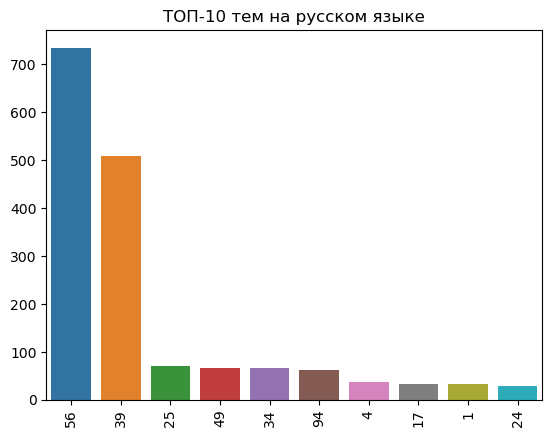

In [129]:
top10topic_ru = df_posts_ru['topic'].value_counts().head(10)
sns.barplot(x=top10topic_ru.index, y=top10topic_ru.values, order=top10topic_ru.index).set_title('ТОП-10 тем на русском языке')
plt.xticks(rotation=90)
plt.show()

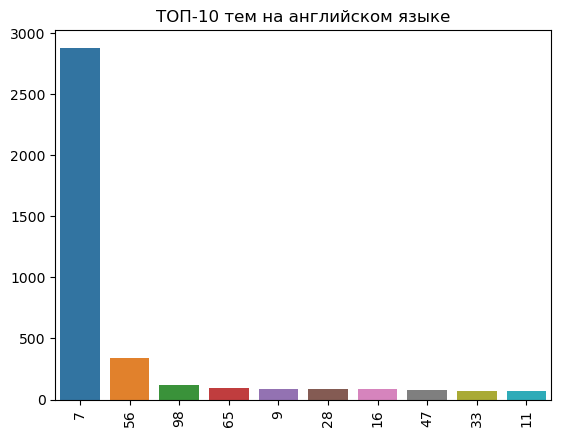

In [130]:
top10topic_en = df_posts_en['topic'].value_counts().head(10)
sns.barplot(x=top10topic_en.index, y=top10topic_en.values, order=top10topic_en.index).set_title('ТОП-10 тем на английском языке')
plt.xticks(rotation=90)
plt.show()

# Формулирование топ-10 тем постов

Номера тем не дают нам никакой информации. Сформулируем их по-человечески. А для этого посмотрим ключевые слова и типичные тексты

## Ключевые слова и типичные статьи для топ-10 тем

Предварительно создадим списки с номерами тем для последующего создания словарей

In [65]:
top10list_ru = top10topic_ru.index
top10list_en = top10topic_en.index

Взглянем на ключевые слова по каждой теме. Для этого напишем функцию

In [66]:
def topic_text(id2word, lda, topics, posts, top10list=top10list_ru):
    for topic in top10list:
        c = lda.components_[topic, :]
        topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
        doc_id = np.argmax(topics[:, topic])
        print("Тема",topic, ":")
        print(", ".join(topic_tokens))
        print("***************************")
        print("Текст на тему",topic, ":")
        print(posts.loc[doc_id]['post'])
        print("\n ")

### Русский язык

In [67]:
topic_text(id2word_ru, lda_ru, topics_ru, df_posts_ru)

Тема 56 :
возможность, работать, команда, которые, новый, ваш, жизнь, первый, проект, время, год, весь, хороший, компания, человек, мочь, работа, наш, свой, это
***************************
Текст на тему 56 :
Новые инструменты на базе AI1. Courseau — делайте курсы из чего угодно. Возьмите что-нибудь сложное: видео на YouTube, научную статью или подкаст и превратите это в увлекательный мини-курс. (https://courseau.co/)2. Playtext — превратите любой текст в аудиокнигу и читай в 2 раза быстрее (https://playtext.app/)3. 60sec — сайт с помощью AI за 60 секунд. (https://60sec.site/)4. Simulai — сгенерируйте свой блог с готовыми статьями. (https://www.simulai.co/)5. Ecoute — транскрипция видео (вебинаров) и подсказки. (https://lnkd.in/edzAKaSp)6. TLDV — расширение для Zoom для выделения важных моментов на созвонах. (https://tldv.io/)7. ChatNode — обучайте ChatGPT на ваших собственных данных. (https://https://www.linkedin.com/redir/general-malware-page?url=www%2echatnode%2eai%2F%298. Hushl —улу

По одному тексту и ключевым словам довольно непросто сформулировать общую тему конкретной категории постов, поэтому по каждой теме лучше прочитать несколько текстов и выбрать превалирующий контекст.

Для того, чтобы не загромождать ноутбук множеством текстов приведу пример кода, который использовался для "углубленного чтения" (таким образом обрабатывались тексты на обоих языках)

In [124]:
list(df_posts_ru.query('topic == 24')['post'].sample(20))

['✅ Новая подборка сайтиков на неделю !Пора вдохновляются на предстоящую неделю чтобы создавать новое и прекрасноеЯ собрал для вас 9 сайтов которые меня вдохновили и помогли в проектах!Особенно мне понравилосья reflect.app!Люблю такие проработанные сайты с интересным визуалом web-3.0 и веяньем новых технологий А вот и сам спиоск:1 Props https://lnkd.in/dzpJSYtH2 Design is Funny https://lnkd.in/dBAZseE53 Dior by Starck https://diorbystarck.art/4 TMV STUDIO DESIGN® https://lnkd.in/dER4TnS55 Joga o QUIZ https://lnkd.in/d2AB8zvK6 Absolute Green https://lnkd.in/dCM-RThg7 Reailise http://reailise.com/8 Reflect https://reflect.app/home9 SNOW FOX\xa0https://www.snowfox.art/❓ Пишите какой сайт вам понравился больше всего !Совсем скоро будет крутая активность на канале, очень интерсеный проект !👾 Мой телеграмм канал -\xa0https://lnkd.in/dF6vEVJXТам куча полезногоВ канале:\xa0- Design Help, файл 40+ материалов для повышения ваших скиллов- Розыгрыш консультаций по карьерному треку и разбору портфо

По итогам анализа ключевых слов и текстов ясформулировал следующие темы постов на русском языке:
- развитие/тренды (инструменты, обучение)
- поддержка/коллаборация (различные мысли)
- выход на работу
- поиск работы
- поиск сотрудников
- события (саммиты, конференции, вебинары)
- предложения услуг бизнесу
- новый навык (получен значок на Linkedin)
- анонсы/стартапы
- сайты/статьи/чаты

Сохраним их в словарь:

In [127]:
top10_ru = ['развитие/тренды',
            'поддержка/коллаборация',
            'выход на работу',
            'поиск работы',
            'поиск сотрудников',
            'события',
            'предложения бизнес-услуг',
            'новый навык',
            'анонсы/стартапы',
            'сайты/статьи/чаты']

topics_ru_dict = dict(zip(top10list_ru, top10_ru))

topics_ru_dict

{56: 'развитие/тренды',
 39: 'поддержка/коллаборация',
 25: 'выход на работу',
 49: 'поиск работы',
 34: 'поиск сотрудников',
 94: 'события',
 4: 'предложения бизнес-услуг',
 17: 'новый навык',
 1: 'анонсы/стартапы',
 24: 'сайты/статьи/чаты'}

### Английский язык

In [68]:
topic_text(id2word_en, lda_en, topics_en, df_posts_en, top10list_en)

Тема 7 :
ai, make, use, get, like, experience, need, new, company, one, data, product, help, time, project, work, team, business, software, development
***************************
Текст на тему 7 :
Hi there 👋 How is Bitrix24 better than 99% of other solutions on the market?✔ replaces all your current SaaS solutions;✔ free forever for unlimited users;✔ easy to migrate data from other systems;✔ integrated with all your favorite services and applications;✔ used, liked and trusted by 12,000,000+ users worldwide;✔ 100% fixed fee: predictable costs, no pricing per user.Instead of dozens of services and apps, start using a single platform to organise your entire company.#itachsoft #bitrix24 #automatization #business #crm #it #sales #software

 
Тема 56 :
commerce, people, possible, bring, part, technologies, digital, professionals, ideas, new, insights, goals, potential, community, skills, us, world, future, together, also
***************************
Текст на тему 56 :
Strolling down Wall Str

Аналогично работе с русским языком, просмотрел больше текстов по каждой популярной теме и сформулировал их так:
- развитие/тренды
- поддержка/коллаборация
- события
- сайты/статьи/чаты
- поиск работы
- выход на работу
- анонсы/стартапы
- новый навык
- AI/ML
- поиск сотрудников

Практически все темы присутствуют и в русскоязычном сегменте, однако популярность их отличается. Сформируем словарь:

In [131]:
top10_en = ['развитие/тренды',
            'поддержка/коллаборация',
            'события',
            'сайты/статьи/чаты',
            'поиск работы',
            'выход на работу',
            'анонсы/стартапы',
            'новый навык',
            'AI/ML',
            'поиск сотрудников']

topics_en_dict = dict(zip(top10list_en, top10_en))
topics_en_dict

{7: 'развитие/тренды',
 56: 'поддержка/коллаборация',
 98: 'события',
 65: 'сайты/статьи/чаты',
 9: 'поиск работы',
 28: 'выход на работу',
 16: 'анонсы/стартапы',
 47: 'новый навык',
 33: 'AI/ML',
 11: 'поиск сотрудников'}

Выполним более интерпретируемый анализ по популярным темам

# Анализ по темам

Сформируем датафреймы, которые содержат посты популярных тем

In [150]:
df_top10_ru = df_posts_ru.copy()
df_top10_ru = df_top10_ru.query('topic in @top10list_ru')

df_top10_en = df_posts_en.copy()
df_top10_en = df_top10_en.query('topic in @top10list_en')

display(df_top10_ru.sample(5))
df_top10_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
806,https://www.linkedin.com/in/%D0%B0%D0%BD%D0%B3...,0,Сегодня впервые написали мне предложение о раб...,12,6.0,0.0,ru,245,39
377,https://www.linkedin.com/in/%D0%B4%D0%B0%D1%80...,0,DreamDocs примет участие в «CNews FORUM Кейсы:...,0,0.0,0.0,ru,422,39
1722,https://www.linkedin.com/in/tataslovak/recent-...,0,"Делюсь подробностями воркшопа ""Figma Component...",4,1.0,0.0,ru,815,56
1404,https://www.linkedin.com/in/yuliii/recent-acti...,0,Сегодня наступает день очередной раз избить мо...,15,0.0,0.0,ru,810,56
221,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5...,0,Приглашаем на вебинар от образовательного прое...,2,0.0,1.0,ru,773,94


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
3689,https://www.linkedin.com/in/katerynaovchar/rec...,0,🔋Charge & Go — is wireless charging as promisi...,6,4.0,0.0,en,1333,65
3062,https://www.linkedin.com/in/alina-klimakhovich...,0,"🔥 Great news! You can find us in Sofia, Bulgar...",0,0.0,0.0,en,402,98
5536,https://www.linkedin.com/in/jasurkurbanov/rece...,0,I am excited to announce the launch of our my...,7,0.0,0.0,en,289,28
5321,https://www.linkedin.com/in/andrrey/recent-act...,0,This Friday 13th marks new page in my professi...,40,0.0,0.0,en,246,7
5770,https://www.linkedin.com/in/polina-kharina-qua...,0,Hi everyone - I am looking for a new role and ...,17,1.0,4.0,en,170,9


Заменим номера тем их сформулированными ранее текстами

In [151]:
def rutopic_num_to_text(num):
    return topics_ru_dict[num]

df_top10_ru['topic_text'] = df_top10_ru['topic'].apply(rutopic_num_to_text)
df_top10_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic,topic_text
37,https://www.linkedin.com/in/%D0%B0%D0%BD%D0%B4...,0,"Всем привет, сегодня мы всей семьёй улетаем в ...",0,0.0,0.0,ru,771,39,поддержка/коллаборация
1988,https://www.linkedin.com/in/raushan-akayeva/re...,0,100500 различий жизни в Америке и КазахстанеМе...,17,0.0,0.0,ru,1806,56,развитие/тренды
708,https://www.linkedin.com/in/shoshiev/recent-ac...,0,Дизайн интернет каталога электронных компонент...,4,0.0,0.0,ru,84,4,предложения бизнес-услуг
1690,https://www.linkedin.com/in/ruslan-kochubarov/...,0,⚠️⚠️⚠️ 52 дизайн системы для вашей работы!Прод...,293,1.0,46.0,ru,931,24,сайты/статьи/чаты
1281,https://www.linkedin.com/in/abdelhai95/recent-...,0,Друзья привет. Уже несколько месяцев думаю о с...,907,119.0,124.0,ru,601,56,развитие/тренды


In [152]:
def entopic_num_to_text(num):
    return topics_en_dict[num]

df_top10_en['topic_text'] = df_top10_en['topic'].apply(entopic_num_to_text)
df_top10_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic,topic_text
5042,https://www.linkedin.com/in/justjeb/recent-act...,0,Yesterday Kobi Kadosh raised some concerns in ...,2,1.0,0.0,en,2501,7,развитие/тренды
3238,https://www.linkedin.com/in/romanhutnyk/recent...,0,“Customers are coming to expect an easier time...,19,0.0,2.0,en,974,7,развитие/тренды
5932,https://www.linkedin.com/in/matohin,0,"I like Dalio's principles a lot, so decided to...",1.0,0.0,0.0,en,126,98,события
4250,https://www.linkedin.com/in/nikita-skorobogach...,0,Discover a thriving community of over 100 deve...,9,0.0,0.0,en,393,7,развитие/тренды
4916,https://www.linkedin.com/in/raiars/recent-acti...,0,I became an NPC and why I'm glad I did.An NPC ...,0,0.0,0.0,en,680,7,развитие/тренды


Готово. Сформируем общий датасет по двум языкам и решим вопрос со столбцом `comments_cnt`, в котором присутствуют разнородные данные. Придётся заменить запятые и пробелы на точки, чтобы в итоге привести столбец к типу `float`

In [185]:
df_top10 = pd.concat([df_top10_en, df_top10_ru])

In [204]:
def reactions_type(x):
    x = str(x)
    if x.__contains__(',') == True:
        x = x.replace(',', '.')
        return x
    elif x.__contains__(' ') == True:
        x = x.replace(' ', '.')
        return x
    return x

df_top10['reactions_cnt'] = df_top10['reactions_cnt'].apply(reactions_type).astype('float')

## Сводные таблицы

Построим сводную таблицу, показывающую информацию по каждой теме в разрезе по языкам: средние и медианные значения количества реакций, комментариев, репостов, а также среднее и медианное значение длины поста.

Также будут и максимальные значения

In [207]:
pd.pivot_table(df_top10, index=['topic_text', 'language'], values=['reactions_cnt', 'comments_cnt', 'reposts_cnt', 'post_len'], aggfunc=['mean', 'median', 'max'])

mean                             \
                                  comments_cnt     post_len reactions_cnt   
topic_text               language                                           
AI/ML                    en          18.361111   325.111111     30.686514   
анонсы/стартапы          en          10.867470   372.060241     24.575422   
                         ru          13.151515   607.454545     53.842152   
выход на работу          en          11.552941   168.705882     21.074553   
                         ru           8.485714   140.414286     24.719400   
новый навык              en           1.933333   204.466667     24.866667   
                         ru           0.484848   143.727273     20.666667   
поддержка/коллаборация   en           8.514881   576.288690     24.987949   
                         ru           4.844488   886.620079     18.984252   
поиск работы             en           1.617978   202.741573     20.134831   
                         ru           0.833333   243.030303     12.742424   
поиск сотрудников        en           0.147059   457.235294      3.323529   
                         ru           1.369231   838.046154     16.815385   
предложения бизнес-услуг ru           0.166667   207.638889      3.861111   
развитие/тренды          en          11.938542   843.444097     20.900023   
                         ru           5.601361  1169.337415     27.057824   
сайты/статьи/чаты        en          17.065934   484.637363     20.033132   
                         ru           0.571429   624.357143     20.928571   
события                  en           1.106557   236.647541      9.472008   
                         ru           1.377049   604.983607     10.475410   

                                                    median           \
                                  reposts_cnt comments_cnt post_len   
topic_text               language                                     
AI/ML                    en         23.944444          0.0    229.5   
анонсы/стартапы          en          1.144578          0.0    288.0   
                         ru         20.939394          0.0    416.0   
выход на работу          en          0.376471          0.0     89.0   
                         ru          0.142857          1.0    109.5   
новый навык              en          1.186667          0.0    159.0   
                         ru          0.727273          0.0    140.0   
поддержка/коллаборация   en         12.395833          0.0    443.5   
                         ru          1.381890          0.0    663.0   
поиск работы             en          2.898876          1.0    170.0   
                         ru          2.121212          0.0    208.0   
поиск сотрудников        en          0.411765          0.0     71.0   
                         ru          1.507692          0.0    675.0   
предложения бизнес-услуг ru          0.111111          0.0    148.5   
развитие/тренды          en         12.031944          0.0    677.0   
                         ru          6.238095          0.0    987.0   
сайты/статьи/чаты        en          9.659341          0.0    311.0   
                         ru          1.928571          0.0    537.0   
события                  en          1.631148          0.0    176.5   
                         ru          0.590164          0.0    520.0   

                                                                     max  \
                                  reactions_cnt reposts_cnt comments_cnt   
topic_text               language                                          
AI/ML                    en                 5.0         0.0        635.0   
анонсы/стартапы          en                 6.0         0.0        764.0   
                         ru                 3.0         0.0        143.0   
выход на работу          en                 8.0         0.0        705.0   
                         ru                10.5         0.0        427.0   
новый навык              en 

**Выводы**: ???

Выведем ту же информацию, но без раскладки по текстам

In [211]:
pd.pivot_table(df_top10, index=['language'], values=['reactions_cnt', 'comments_cnt', 'reposts_cnt', 'post_len'], aggfunc=['mean', 'median', 'max'])

mean                                             median  \
         comments_cnt    post_len reactions_cnt reposts_cnt comments_cnt   
language                                                                   
en          10.878493  725.153807     20.889552   10.797488          0.0   
ru           4.814679  903.277064     22.641376    3.880122          0.0   

                                                     max           \
         post_len reactions_cnt reposts_cnt comments_cnt post_len   
language                                                            
en            532           6.0         0.0        967.0     2983   
ru            684           5.0         0.0        449.0     2994   

                                    
         reactions_cnt reposts_cnt  
language                            
en               995.0       979.0  
ru               921.0       562.0

**Выводы**: ???

Посчитаем количество текстов по темам и языкам

In [218]:
pd.pivot_table(df_top10, index=['topic_text', 'language'], values='topic', aggfunc=['count']).transpose()

topic_text  AI/ML анонсы/стартапы     выход на работу     новый навык      \
language       en              en  ru              en  ru          en  ru   
count topic    72              83  33              85  70          75  33   

topic_text  поддержка/коллаборация      поиск работы     поиск сотрудников  \
language                        en   ru           en  ru                en   
count topic                    336  508           89  66                68   

topic_text      предложения бизнес-услуг развитие/тренды       \
language     ru                       ru              en   ru   
count topic  65                       36            2880  735   

topic_text  сайты/статьи/чаты     события      
language                   en  ru      en  ru  
count topic                91  28     122  61

Для большей наглядности представим в виде графика

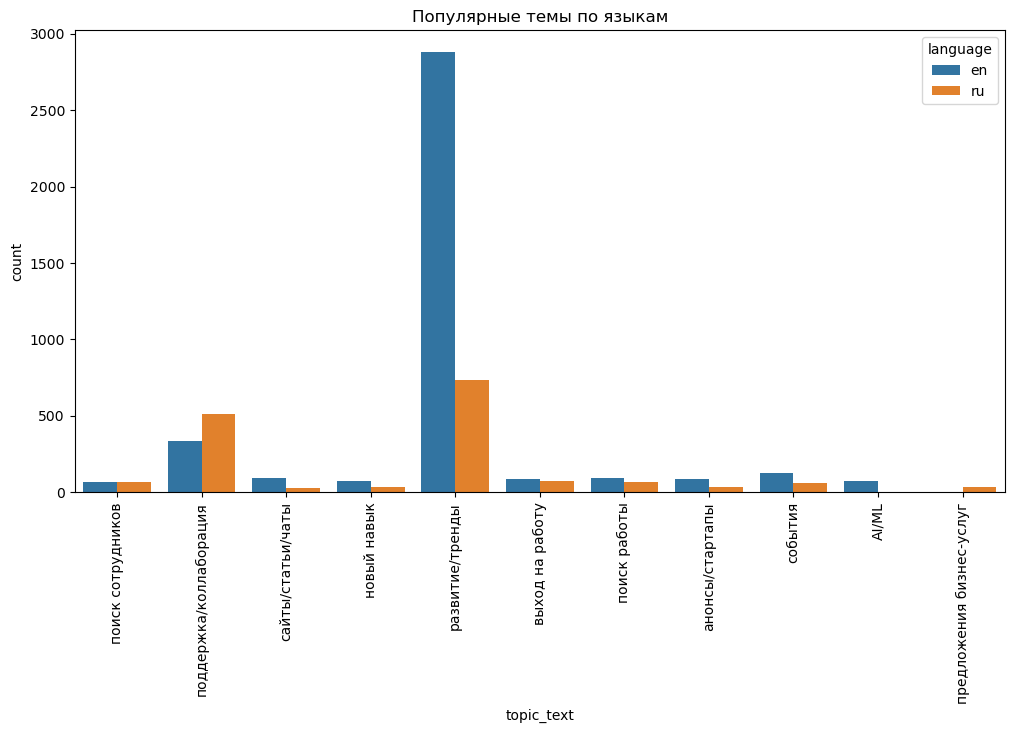

In [214]:
plt.figure(figsize=(12, 6))
sns.countplot(df_top10, x=df_top10['topic_text'], hue='language').set_title('Популярные темы по языкам')
plt.xticks(rotation=90)
plt.show()

**Выводы**: ???